In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/aiai20202-csv/ai4i2020.csv


In [2]:
!ls /kaggle/input


aiai20202-csv


In [3]:
import os
import pandas as pd

print("Folders inside /kaggle/input:")
print(os.listdir('/kaggle/input'))

csv_files = []

for root, dirs, files in os.walk('/kaggle/input'):
    for file in files:
        if file.endswith('.csv'):
            csv_files.append(os.path.join(root, file))

print("CSV files found:", csv_files)

df = pd.read_csv(csv_files[0])
df.head()


Folders inside /kaggle/input:
['aiai20202-csv']
CSV files found: ['/kaggle/input/aiai20202-csv/ai4i2020.csv']


,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [4]:
print("Dataset Shape:", df.shape)
df.info()


Dataset Shape: (10000, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
d

In [6]:
# CELL 4: Dataset Size Check (10,000 – 100,000 rows)

num_rows = df.shape[0]
print("Original dataset size:", num_rows)

# If dataset is too small
if num_rows < 10000:
    raise ValueError(
        f"Dataset too small ({num_rows} rows). "
        "Minimum required is 10,000 rows."
    )

# If dataset is too large, sample down
elif num_rows > 100000:
    df = df.sample(n=100000, random_state=42)
    print("Dataset was large → sampled down")


Original dataset size: 10000


In [9]:
df.columns = (
    df.columns
      .str.strip()
      .str.lower()
      .str.replace(" ", "_")
)

df.head()


,udi,product_id,type,air_temperature_[k],process_temperature_[k],rotational_speed_[rpm],torque_[nm],tool_wear_[min],machine_failure,twf,hdf,pwf,osf,rnf
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


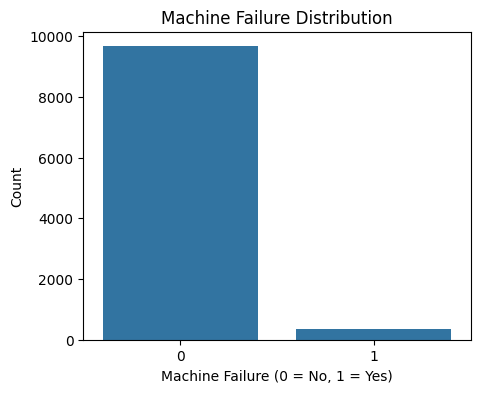

In [12]:
# CELL 5: Target distribution (corrected)

import matplotlib.pyplot as plt
import seaborn as sns

# Percentage distribution
df['machine_failure'].value_counts(normalize=True) * 100
# Plot class distribution
plt.figure(figsize=(5,4))
sns.countplot(x='machine_failure', data=df)
plt.title("Machine Failure Distribution")
plt.xlabel("Machine Failure (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()



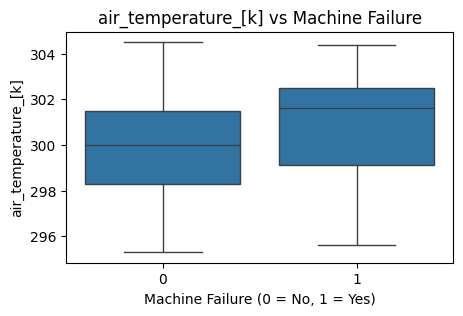

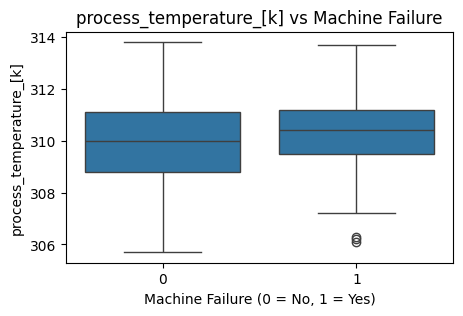

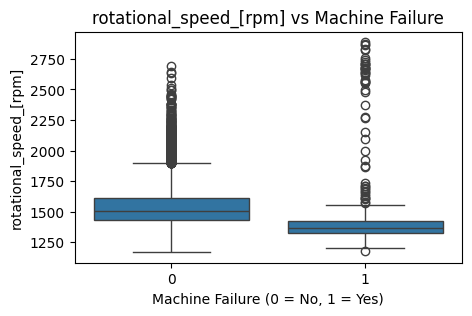

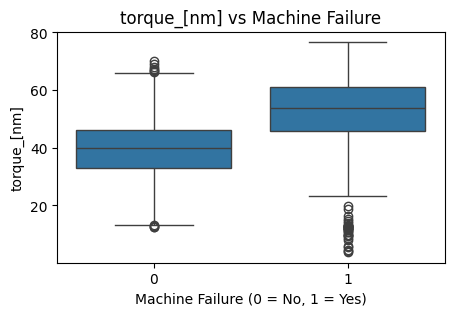

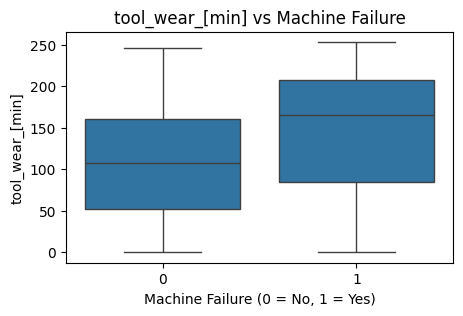

In [15]:
# CELL 6: Sensor statistics by failure class (AI4I correct columns)

sensor_cols = [
    'air_temperature_[k]',
    'process_temperature_[k]',
    'rotational_speed_[rpm]',
    'torque_[nm]',
    'tool_wear_[min]'
]

# Mean sensor values for failure vs no-failure
df.groupby('machine_failure')[sensor_cols].mean()

import matplotlib.pyplot as plt
import seaborn as sns

for col in sensor_cols:
    plt.figure(figsize=(5,3))
    sns.boxplot(x='machine_failure', y=col, data=df)
    plt.title(f"{col} vs Machine Failure")
    plt.xlabel("Machine Failure (0 = No, 1 = Yes)")
    plt.ylabel(col)
    plt.show()



In [16]:
# CELL 7: Feature engineering using industrial domain knowledge

# Temperature interaction
df['temp_diff'] = df['process_temperature_[k]'] - df['air_temperature_[k]']

# Mechanical power proxy (physics-inspired feature)
df['power_proxy'] = df['torque_[nm]'] * df['rotational_speed_[rpm]']

# Wear normalized by speed (stress indicator)
df['wear_speed_ratio'] = df['tool_wear_[min]'] / (df['rotational_speed_[rpm]'] + 1)

# Inspect newly created features
df[['temp_diff', 'power_proxy', 'wear_speed_ratio']].head()


,temp_diff,power_proxy,wear_speed_ratio
0,10.5,66382.8,0.000000
1,10.5,65190.4,0.002129
2,10.4,74001.2,0.003336
3,10.4,56603.5,0.004881
4,10.5,56320.0,0.006388


In [17]:
y = df['machine_failure']
X = df.drop(columns=['machine_failure'])

print(X.shape)
print(y.shape)

X.head()


(10000, 16)
(10000,)


,udi,product_id,type,air_temperature_[k],process_temperature_[k],rotational_speed_[rpm],torque_[nm],tool_wear_[min],twf,hdf,pwf,osf,rnf,temp_diff,power_proxy,wear_speed_ratio
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,10.5,66382.8,0.000000
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,10.5,65190.4,0.002129
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,10.4,74001.2,0.003336
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,10.4,56603.5,0.004881
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,10.5,56320.0,0.006388


In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(8000, 16)
(2000, 16)
(8000,)
(2000,)


In [27]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

numeric_features = X.select_dtypes(include='number').columns
categorical_features = ['type']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)


In [26]:
X_train_p = preprocessor.fit_transform(X_train)
X_test_p = preprocessor.transform(X_test)
